In [14]:
import os
import pickle 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics
from sklearn import multioutput

In [2]:
from ipywidgets import IntProgress
from IPython.display import display

Loading the data

In [3]:
cwd = os.getcwd()
x = pd.read_csv(os.path.join(cwd, '../../INSTANCES/chosen_data/data_x.csv'))
y = pd.read_csv(os.path.join(cwd, '../../INSTANCES/chosen_data/data_y.csv'))

In [4]:
x = x.drop(columns=['instance_id'])
y = y.drop(columns=['instance_id'])

In [5]:
def log10_transform_data(data):
    minimum_log10_value = 0.001
    data[data < minimum_log10_value] = minimum_log10_value
    return np.log10(data)

In [6]:
y = log10_transform_data(y)

In [7]:
number_of_solvers = y.shape[1]
number_of_solvers

31

In [8]:
solver_names = y.columns

Splitting the data for training and testing

In [9]:
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 7)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_val, y_train_val, test_size = 0.3, random_state = 7)

Scaling the data

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

scaler = preprocessing.StandardScaler()
scaler.fit(x_train_val)
x_train_val = scaler.transform(x_train_val)
x_test = scaler.transform(x_test)

Finding the best configuration using validation set

In [11]:
max_features = ['auto', 'sqrt', 'log2', 2, 5, 10, 20, 50, None]
n_estimators = [10, 20, 50, 100, 200, 500, 1000]
min_samples_split = [0.2, 0.4, 0.6, 0.8, 1.0, 2, 5, 10]

In [12]:
r2_scores = np.empty((len(max_features), len(n_estimators), len(min_samples_split), number_of_solvers))
rmse_scores = np.empty((len(max_features), len(n_estimators), len(min_samples_split), number_of_solvers))

In [13]:
progress_max = len(max_features) * len(n_estimators) * len(min_samples_split) * number_of_solvers
progress_bar = IntProgress(min=0, max=progress_max)

In [17]:
display(progress_bar)

for i in range(len(max_features)):
    param_max_features = max_features[i]
    for j in range(len(n_estimators)):
        param_n_estimators = n_estimators[j]
        for k in range(len(min_samples_split)):
            param_min_samples_split = min_samples_split[k]
            for l in range(number_of_solvers):
                model = ensemble.RandomForestRegressor(
                    max_features=param_max_features, 
                    n_estimators=param_n_estimators, 
                    min_samples_split=param_min_samples_split, 
                    n_jobs=-1)
                model.fit(x_train, np.ravel(y_train.iloc[:, l:l+1]))
                y_true, y_pred = y_val.iloc[:, l:l+1], model.predict(x_val)
                r2_score = metrics.r2_score(y_true, y_pred)
                r2_scores[i, j, k, l] = r2_score
                rmse_score = metrics.mean_squared_error(y_true, y_pred, squared=False)
                rmse_scores[i, j, k, l] = rmse_score
                progress_bar.value += 1

IntProgress(value=592, max=15624)

In [18]:
with open('../../models/RF_model_search_results.csv', 'w', encoding='utf-8') as csv:
    csv.write('max_features,n_estimators,min_samples_split,solver name,r2 score,rmse score\n')
    for i in range(len(max_features)):
        param_max_features = max_features[i]
        for j in range(len(n_estimators)):
            param_n_estimators = n_estimators[j]
            for k in range(len(min_samples_split)):
                param_min_samples_split = min_samples_split[k]
                for l in range(number_of_solvers):
                    solver_name = solver_names[l]
                    row = f'{param_max_features},{param_n_estimators},{param_min_samples_split},{solver_name},{r2_scores[i, j, k, l]},{rmse_scores[i, j, k, l]}\n'
                    csv.write(row)

In [19]:
with open('../../models/RF_model_search_group_results.csv', 'w', encoding='utf-8') as csv:
    csv.write('max_features,n_estimators,min_samples_split,avg r2 score,min r2 score,max r2 score,avg rmse score,min rmse score,max rmse score\n')
    for i in range(len(max_features)):
        param_max_features = max_features[i]
        for j in range(len(n_estimators)):
            param_n_estimators = n_estimators[j]
            for k in range(len(min_samples_split)):
                param_min_samples_split = min_samples_split[k]
                avg_r2_score = np.average(r2_scores[i, j, k])
                min_r2_score = np.min(r2_scores[i, j, k])
                max_r2_score = np.max(r2_scores[i, j, k])
                avg_rmse_score = np.average(rmse_scores[i, j, k])
                min_rmse_score = np.min(rmse_scores[i, j, k])
                max_rmse_score = np.max(rmse_scores[i, j, k])
                row = f'{param_max_features},{param_n_estimators},{param_min_samples_split},{avg_r2_score},{min_r2_score},{max_r2_score},{avg_rmse_score},{min_rmse_score},{max_rmse_score}\n'
                csv.write(row)

Evaluate the best model

In [20]:
train_data = pd.read_csv('../../models/RF_model_search_group_results.csv')
avg_r2_score = train_data['avg r2 score']
idx = np.argmax(avg_r2_score)
best_data = train_data.iloc[idx]
best_data

max_features             None
n_estimators             1000
min_samples_split           2
avg r2 score         0.671203
min r2 score         0.602978
max r2 score         0.750644
avg rmse score       0.844299
min rmse score       0.645064
max rmse score        0.98186
Name: 501, dtype: object

In [26]:
best_params = { 
    'max_features': None if best_data['max_features'] == 'None' else best_data['max_features'], 
    'n_estimators': best_data['n_estimators'],
    'min_samples_split': int(best_data['min_samples_split']) if int(best_data['min_samples_split']) == best_data['min_samples_split'] else best_data['min_samples_split']
}

In [27]:
best_model = multioutput.MultiOutputRegressor(ensemble.RandomForestRegressor(**best_params, n_jobs=-1))
best_model.fit(x_train_val, y_train_val)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=1000,
                                               

In [28]:
y_true, y_pred = y_test, best_model.predict(x_test)
r2_scores_test = np.empty((number_of_solvers, ))
rmse_scores_test = np.empty((number_of_solvers, ))
for i in range(number_of_solvers):
    r2_scores_test[i] = metrics.r2_score(y_true.iloc[:, i:i+1], y_pred[:, i:i+1])
    rmse_scores_test[i] = metrics.mean_squared_error(y_true.iloc[:, i:i+1], y_pred[:, i:i+1], squared=False)

In [29]:
r2_score_test_avg = np.average(r2_scores_test)
rmse_score_test_avg = np.average(rmse_scores_test)
print(f'Average R2 score: {r2_score_test_avg}, Average RMSE score: {rmse_score_test_avg}')

Average R2 score: 0.7045849132028864, Average RMSE score: 0.8551826914493682


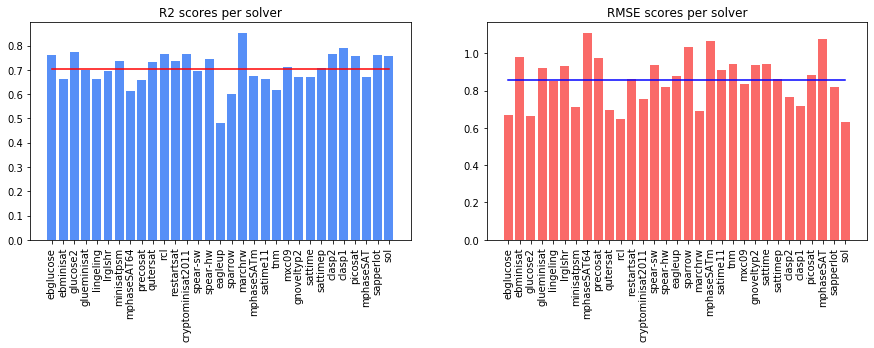

In [34]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
xticks = range(1, len(r2_scores_test)+1)
plt.title('R2 scores per solver')
plt.xticks(ticks=xticks, labels=list(solver_names), rotation=90)
plt.bar(xticks, r2_scores_test, color='#578FF7')
plt.plot([xticks[0], xticks[-1]], [r2_score_test_avg, r2_score_test_avg], 'r-')

plt.subplot(1, 2, 2)
xticks = range(1, len(rmse_scores_test)+1)
plt.title('RMSE scores per solver')
plt.xticks(ticks=xticks, labels=list(solver_names), rotation=90)
plt.bar(xticks, rmse_scores_test, color='#FA6A68')
plt.plot([xticks[0], xticks[-1]], [rmse_score_test_avg, rmse_score_test_avg], 'b-')

Saving the best RF model to a file

In [31]:
with open('../../models/best_rf_model', 'wb') as model_file:
    pickle.dump(best_model, model_file)